In [1]:
#load package
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import seaborn as sns

from skimage import measure
from skimage.segmentation import clear_border
from skimage.morphology import skeletonize, binary_closing

In [2]:
from skimage.filters import sobel

def Genfeature(img):
    img = img.reshape(28,28)    
    img_features = np.array([])     
    # FEATURE 1 - Pixel values
    #Add pixel values to the data frame
    pixel_values = img.reshape(-1)
    img_features = np.concatenate((img_features,pixel_values), axis=0)

    # FEATURE 2 - Bunch of Gabor filter responses
    #Generate Gabor features
    for theta in range(8):   #Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 5):  #Sigma with 1 and 3
            lamda = np.pi/4
            gamma = 0.5
            ksize=9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
            
            #Now filter the image and add values to a new column 
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            img_features = np.concatenate((img_features,filtered_img), axis=0)
     
    # FEATURE 3 Sobel
    edge_sobel = sobel(img)
    edge_sobel = edge_sobel.reshape(-1)
    img_features = np.concatenate((img_features,edge_sobel), axis=0)

    #print('pixel_values.shape: ', filtered_img.shape)

    return img_features


def X_features(train_X, train_y):
    # allocate
    train_X_features = np.zeros((len(train_y), len(Genfeature(train_X[0]))))
    
    # go through each entry
    for i,k in enumerate(train_X):
        train_X_features[i,:] = Genfeature(k)
    return train_X_features

In [3]:
# A Framework to Access Handwritten Information within Large Digitized Paper Collections

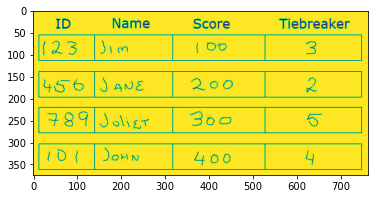

In [4]:
# load as a grayscale image, best used on scanned image
img_url = '/Users/livi/Git/HandWritingRecognization/Examples/SG9AL.jpeg'
img = cv2.imread(img_url,0)
plt.imshow(img)

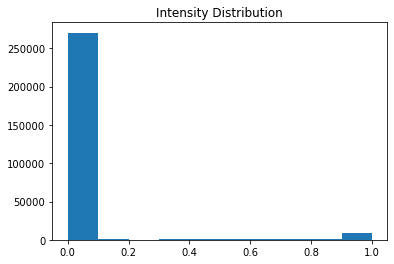

In [5]:
# binarized (background 0, line/text 1)
img = 1-img/255
plt.hist(img.reshape(-1,1)); plt.title('Intensity Distribution');plt.show()
#img = img[img>0.1]
#img = img[20:img.shape[0]-40,20:img.shape[1]-20]

#plt.figure(figsize=(16,8))
#plt.subplot(1,2,1)
#sns.heatmap(img); 

# morphological thinning process (ref 20) for character recognition. (likely to miss hlines)
#plt.subplot(1,2,2)
#img_thin = skeletonize(img)
#sns.heatmap(img_thin); 
#plt.show()

#Hough transformation
# rotate image by detecting long horizontal lines with Hough transform.
## histogram of angles of these lines, based on the angle to rotate
# after rotation, verticle and horizontal pixel histogram gves the location.
# we build one template, and fnd lines that match the template
#(dot product, or dynamic time warping). Horizontal/vertical can run separately.

(374, 763)


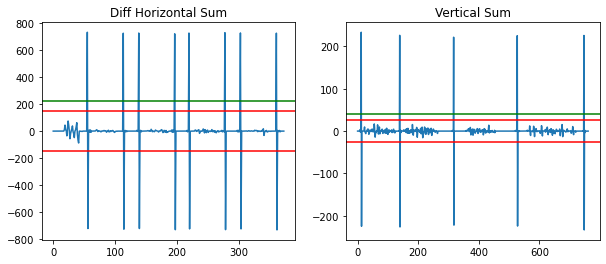

In [6]:
horizontal_sum = img.sum(axis=1)
vertical_sum = img.sum(axis=0)

# find loc read more than Q3 intensity.
h_diff = np.diff(horizontal_sum)
v_diff = np.diff(vertical_sum)
ax0_criteria, ax1_criteria = [np.mean(i)+1.5*np.std(i) for i in [h_diff, v_diff]]
#np.quantile(horizontal_sum,0.95), np.quantile(vertical_sum,0.95)

# image shape
print(img.shape)

plt.figure(figsize=(10,4))
# horizontal sum
plt.subplot(1,2,1)#; plt.plot(horizontal_sum); plt.hlines(ax0_criteria, 0, 300, 'r')
plt.plot(h_diff)
plt.axhline(np.mean(h_diff)+np.std(h_diff),c='r')
plt.axhline(np.mean(h_diff)-np.std(h_diff),c='r')
plt.axhline(ax0_criteria,c='g')
plt.title('Diff Horizontal Sum')
# vertical sumss
plt.subplot(1,2,2)#;plt.plot(vertical_sum); #plt.hlines(ax1_criteria, 0, 300, 'r')
plt.plot(v_diff)
plt.axhline(np.mean(v_diff)+np.std(v_diff),c='r')
plt.axhline(np.mean(v_diff)-np.std(v_diff),c='r')
plt.axhline(ax1_criteria,c='g')
plt.title('Vertical Sum')
plt.show()

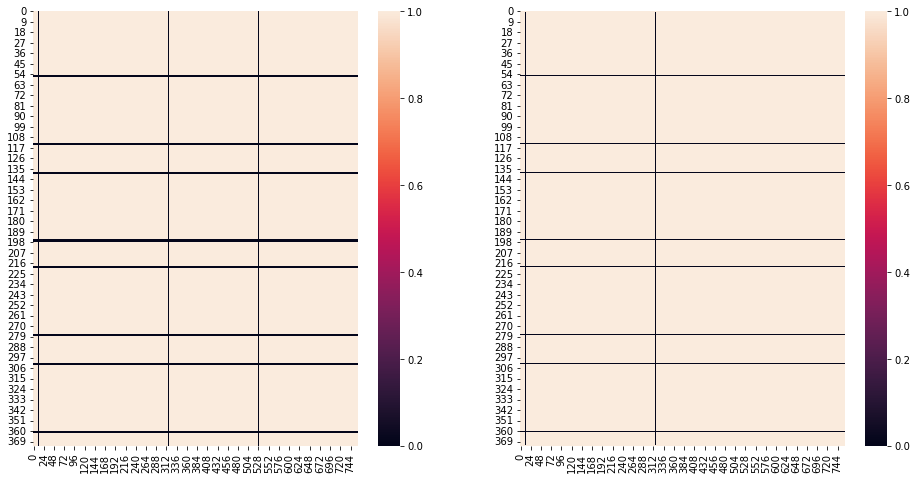

In [7]:
# draw cells
frame= np.zeros((img.shape[0]-1, img.shape[1]-1))
frame[h_diff>ax0_criteria,:]=1
frame[:,v_diff>ax1_criteria]=1
frame[h_diff<-1*ax0_criteria,:]=1
frame[:,v_diff<-1*ax1_criteria]=1

# merge lines that are closed to each other
frame_close = skeletonize(binary_closing(frame))
plt.figure(figsize=(16,8))
plt.subplot(1,2,1);sns.heatmap(1-frame)
plt.subplot(1,2,2);sns.heatmap(1-frame_close)
plt.show()

frame = frame_close

In [8]:
frame = 255*(1-frame.astype(int))

## Filter img_0 based on Frame

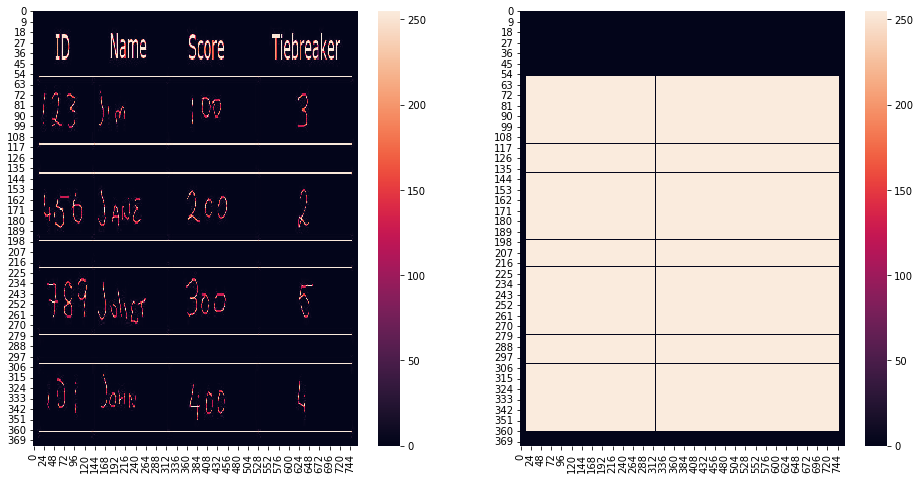

In [9]:
img_0 = 255-cv2.imread(img_url,0)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1);sns.heatmap(img_0)
plt.subplot(1,2,2);sns.heatmap(clear_border(frame))
plt.show()

In [10]:
frame = clear_border(frame)
frame_label = measure.label(frame)
smaller_regionNum=[]
area = {}
img_int = []

regions = measure.regionprops(frame_label)
for i, region in enumerate(regions):

    x1, y1, x2, y2= region.bbox
    img_int.append(np.sum(img_0[x1:x2, y1:y2]))
    
    area[i] = region.area
    if region.area<100:
        smaller_regionNum.append(region.label)
        #print(region.label,': ', region.area)

# reason for area < 100
print('# of Regions Smaller than 100: ', len(smaller_regionNum))
#smaller100= [i in smaller_regionNum for i in np.unique(frame_label)]

# of Regions Smaller than 100:  0


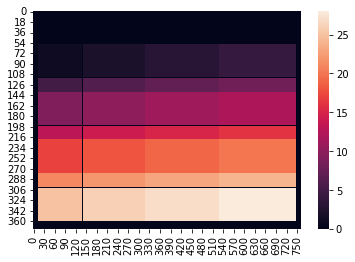

In [11]:
sns.heatmap(frame_label)
plt.show()

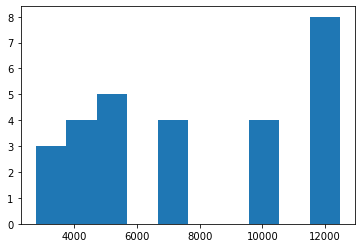

0.44582105120738863

In [12]:
area_list = list(area.values())
CoefVar = np.std(area_list)/np.mean(area_list)
plt.hist(area.values())
plt.show()
CoefVar

## Prediction

In [13]:
import pickle
import imutils
from imutils.contours import sort_contours

In [14]:
with open('letters rfc model.pkl', 'rb') as f:
    l_rfc = pickle.load(f)


with open('both rfc model.pkl', 'rb') as f:
    both_rfc = pickle.load(f)

In [15]:
def norm_img(image):
	# initialize the list of contour bounding boxes and associated
	# characters that we'll be OCR'ing
	chars = []
	try:
		image = image/np.max(image)*255
		image = image.astype(np.uint8)
		gray = image #cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		blurred = cv2.GaussianBlur(gray, (3, 3), 0)
		edged = cv2.Canny(blurred, 20, 80)

		cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		cnts = sort_contours(cnts, method="left-to-right")[0]

		

		# loop over the contours
		for c in cnts:
			# compute the bounding box of the contour
			(x, y, w, h) = cv2.boundingRect(c) 
			#plt.imshow(gray[y:y + h, x:x + w]);plt.show()

			# filter out bounding boxes, ensuring they are neither too small
			# nor too large
			if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
				# extract the character and threshold it to make the character
				# appear as *white* (foreground) on a *black* background, then
				# grab the width and height of the thresholded image
				roi = gray[y:y + h, x:x + w]
				thresh = cv2.threshold(roi, 0, 255,
					cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
				(tH, tW) = thresh.shape
				# if the width is greater than the height, resize along the
				# width dimension
				if tW > tH:
					thresh = imutils.resize(thresh, width=32)

				# otherwise, resize along the height
				else:
					thresh = imutils.resize(thresh, height=32)

				# re-grab the image dimensions (now that its been resized)
				# and then determine how much we need to pad the width and
				# height such that our image will be 28x28
				(tH, tW) = thresh.shape
				dX = int(max(0, 28 - tW) / 2.0)+2
				dY = int(max(0, 28 - tH) / 2.0)+2

				# pad the image and force 28x28 dimensions
				padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
					left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
					value=(0, 0, 0))
				padded = cv2.resize(padded, (28, 28))

				# prepare the padded image for classification via our
				# handwriting OCR model
				padded = padded.astype("float32") / 255.0
				padded = np.expand_dims(padded, axis=-1)

				# update our list of characters
				chars.append((padded, (x, y, w, h)))
		# extract the bounding box locations and padded characters
		boxes = [b[1] for b in chars]
		results = np.array([c[0] for c in chars], dtype="float32")

		return boxes,results
	except: print('no image'); return chars

In [16]:
label = {i:str(i) for i in range(10)}
for i in range(10,36,1):
    label[i] = chr(i+55)

nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image
nothing in image


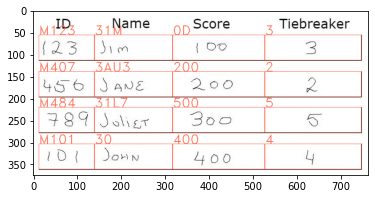

In [18]:
#img_copy=img_0.copy()
img_copy = cv2.imread('Examples/SG9AL.jpeg')
idx = [i for i,k in enumerate(area_list) if k>000]
img_int = []
soft_region = 0
for i in idx:
    x1, y1, x2, y2= regions[i].bbox
    if np.sum(img_0[x1:x2, y1:y2])>0:
        image = img_0[x1-soft_region:x2+soft_region, y1-soft_region:y2+soft_region]
        boxes, chars = norm_img(image)
        char_len = len(chars)
        if char_len>0:
            #plt.imshow(image)
            #plt.show()
            #plt.imshow(chars.reshape(-1,28))
            #plt.show()
            chars_feature = X_features(train_X=chars*255, train_y=np.zeros(char_len))
            # letter model
            letter_label = ''.join([label[i] for i in l_rfc.predict(chars_feature)])
            both_label = ''.join([label[i] for i in both_rfc.predict(chars_feature)])
            
            image = cv2.rectangle(img_copy, (y1,x1), (y2,x2), color = (255,99,71), thickness=1)
            img_copy=cv2.putText(img = img_copy, text = both_label,color = (255,99,71), org = (y1, x1),fontScale = 1, fontFace = cv2.FONT_HERSHEY_DUPLEX, thickness = 1)

        else: print('nothing in image')
plt.imshow(img_copy)
plt.show()